In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function for logistic link

def simulate_zip_with_covariates(n, beta_pois, beta_zero, seed=None):
    if seed is not None:
        np.random.seed(seed)

    X1 = np.random.normal(0, 1, n)
    X2 = np.random.normal(0, 1, n)

    X = np.column_stack((np.ones(n), X1, X2))

    logit_zi = X @ beta_zero
    prob_zero = expit(logit_zi)  # Apply logistic link

    is_zero = np.random.binomial(1, prob_zero)

    log_mu = X @ beta_pois
    mu = np.exp(log_mu)  # Apply log link

    y_pois = np.random.poisson(mu)

    y = np.where(is_zero == 1, 0, y_pois)
    return pd.DataFrame({
        'X1': X1,
        'X2': X2,
        'mu_pois': mu,
        'p_zero': prob_zero,
        'y': y
    })

beta_pois = np.array([0.5, 0.7, -0.3])     # Intercept and slopes for Poisson
beta_zero = np.array([-1.0, 0.5, 0.8])     # Intercept and slopes for zero inflation
df_zip = simulate_zip_with_covariates(n=1000, beta_pois=beta_pois, beta_zero=beta_zero, seed=42)

print(df_zip.head())

         X1        X2   mu_pois    p_zero  y
0  0.496714  1.399355  1.534022  0.590937  0
1 -0.138264  0.924634  1.134084  0.418380  1
2  0.647689  0.059630  2.548469  0.347862  2
3  1.523030 -0.646937  5.813611  0.319508  5
4 -0.234153  0.698223  1.134992  0.363895  0


In [2]:
from statsmodels.tools.tools import add_constant

X = df_zip[[ "X1", "X2" ]].values
X = add_constant(X)
y = df_zip[[ "y" ]].values

from statsmodels.discrete.count_model import ZeroInflatedPoisson

model = ZeroInflatedPoisson(endog=y,
                            exog=X,
                            exog_infl=X
                           )


modelzip = model.fit()
modelzip.summary()

Optimization terminated successfully.
         Current function value: 1.425151
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                 1000
Model:             ZeroInflatedPoisson   Df Residuals:                      997
Method:                            MLE   Df Model:                            2
Date:                 Fri, 18 Apr 2025   Pseudo R-squ.:                  0.1975
Time:                         02:21:58   Log-Likelihood:                -1425.2
converged:                        True   LL-Null:                       -1775.9
Covariance Type:             nonrobust   LLR p-value:                4.902e-153
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -1.0922      0.123     -8.907      0.000      -1.332      -0.852
inflate_x1        0.5059      0.114      4.426      0.000       0.282       0.730
inflate_x2        0.6924      0.106      6.557      0.000       0.485       0.899
const             0.5198      0.034     15.085      0.000       0.452       0.587
x1                0.6809      0.028     24.722      0.000       0.627       0.735
x2               -0.3111      0.029    -10.843      0.000      -0.367      -0.255
=================================================================================
"""

In [29]:

from typing import Any, Optional

import torch
from torch import Tensor
from torch.distributions import Laplace

from gpytorch.constraints import Interval, Positive
from gpytorch.distributions import base_distributions
from gpytorch.priors import Prior
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

class ZeroInflatedPoissonLikelihood(_OneDimensionalLikelihood):
    def __init__(
        self,
        batch_shape: torch.Size = torch.Size([])
    ) -> None:
        super().__init__()

        self.raw_mu = torch.nn.Parameter(torch.ones(*batch_shape, 1))
        self.raw_pi = torch.nn.Parameter(torch.ones(*batch_shape, 1))
        
        mu_constraint = Positive()
        pi_constraint = Interval(0, 1)
        
        self.register_constraint("raw_mu", mu_constraint)
        self.register_constraint("raw_pi", pi_constraint)

    @property
    def mu(self) -> Tensor:
        return self.raw_mu_constraint.transform(self.raw_mu)
        
    @property
    def pi(self) -> Tensor:
        return self.raw_pi_constraint.transform(self.raw_pi)

    @mu.setter
    def mu(self, value: Tensor) -> None:
        self._set_mu(value)
        
    @pi.setter
    def pi(self, value: Tensor) -> None:
        self._set_pi(value)

    def _set_mu(self, value: Tensor) -> None:
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_mu)
        self.initialize(raw_mu=self.raw_mu_constraint.inverse_transform(value))
        
    def _set_pi(self, value: Tensor) -> None:
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_pi)
        self.initialize(raw_pi=self.raw_pi_constraint.inverse_transform(value))

    def forward(self, function_samples: Tensor, *args: Any, **kwargs: Any) -> base_distributions.ZeroInflatedPoisson:
        rate = torch.exp(function_samples)  * self.mu
        #pi = torch.sigmoid(function_samples * self.pi)
        pi = self.pi
        return base_distributions.ZeroInflatedPoisson(rate=rate, gate=pi)

In [4]:
class PoissonLikelihood(_OneDimensionalLikelihood):
    def __init__(
        self,
        batch_shape: torch.Size = torch.Size([])
    ) -> None:
        super().__init__()

        self.raw_mu = torch.nn.Parameter(torch.ones(*batch_shape, 1))
        
        mu_constraint = Positive()
        
        self.register_constraint("raw_mu", mu_constraint)

    @property
    def mu(self) -> Tensor:
        return self.raw_mu_constraint.transform(self.raw_mu)

    @mu.setter
    def mu(self, value: Tensor) -> None:
        self._set_mu(value)
        
    def _set_mu(self, value: Tensor) -> None:
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_mu)
        self.initialize(raw_mu=self.raw_mu_constraint.inverse_transform(value))

    def forward(self, function_samples: Tensor, *args: Any, **kwargs: Any) -> base_distributions.Poisson:
        rate = torch.exp(function_samples) * self.mu
        return base_distributions.Poisson(rate=rate)

In [5]:
import urllib.request
import os
from scipy.io import loadmat
from math import floor
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, DeltaVariationalDistribution, MeanFieldVariationalDistribution
from gpytorch.variational import VariationalStrategy
from sklearn.preprocessing import MinMaxScaler, StandardScaler

N = 500
X = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
y = base_distributions.Poisson(rate=torch.exp(X)).sample().double().cuda().flatten()

In [16]:
import math

class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear2', torch.nn.Linear(1, 500))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(500, 50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50, 1))


class GPModel(ApproximateGP):
    def __init__(self, inducing_points, feature_extractor):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.LinearKernel(),
            # outputscale_prior=gpytorch.priors.SmoothedBoxPrior(y.min(), y.max())
        )
        
        # self.feature_extractor = feature_extractor
        # self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):
        # projected_x = self.feature_extractor(x)
        # projected_x = self.scale_to_bounds(projected_x)  
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

feature_extractor = LargeFeatureExtractor()
inducing_points = X.clone()
M = 30
inducing_points = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
model = GPModel(inducing_points=inducing_points, feature_extractor=feature_extractor).double()
likelihood = ZeroInflatedPoissonLikelihood().double()
likelihood = PoissonLikelihood().double()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

model.train()
#model.covar_module.base_kernel.initialize(lengthscale=5)
likelihood.train()
#likelihood.initialize(mu=200)

variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=y.size(0), lr=0.1)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

n_epochs = 500
for i in range(1, n_epochs + 1):
    if i % (n_epochs // 10) == 0:
        print(i)
        print(loss.item())
    variational_ngd_optimizer.zero_grad()
    hyperparameter_optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y)
    loss.backward()
    variational_ngd_optimizer.step()
    hyperparameter_optimizer.step()

50
1.3169001785181198
100
1.3168870760420692
150
1.3168833873941026
200
1.316879508649663
250
1.3168755216631043
300
1.316871474607568
350
1.3168673981471615
400
1.3168633138733956
450
1.3168592375824122
500
1.3168551811550107


In [17]:
model.eval()
likelihood.eval()
with torch.no_grad():
    preds = likelihood(model(X))

In [18]:
print(
    gpytorch.metrics.negative_log_predictive_density(preds, y).mean().item(),
    gpytorch.metrics.mean_squared_error(preds, y, squared=True).mean().item(),
    gpytorch.metrics.mean_absolute_error(preds, y).mean().item(),
    gpytorch.metrics.quantile_coverage_error(preds, y, quantile=95).mean().item(),
)

0.0026184585134509373 1.4406997864042883 0.8508643313812956 0.006600070279091597


<Axes: xlabel='X1', ylabel='y'>

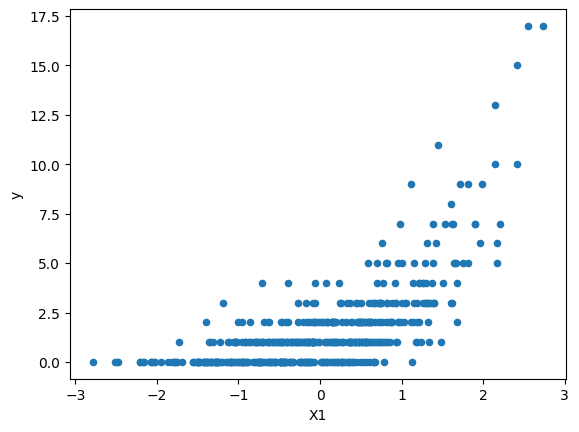

In [19]:
results_df = pd.DataFrame(dict(
    y=y.cpu().numpy(),
    X1=X.cpu().numpy(),
    preds=preds.sample().median(axis=0).values.cpu().numpy()
))

results_df.plot.scatter("X1", "y")

<Axes: xlabel='X1', ylabel='preds'>

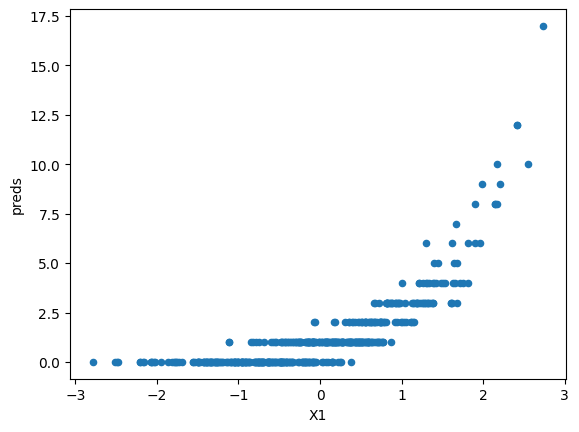

In [20]:
results_df.plot.scatter("X1", "preds")

In [30]:
N = 500
X = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
y = base_distributions.ZeroInflatedPoisson(
    rate=torch.exp(X), gate=torch.tensor([0.25]).double().cuda()
).sample().double().cuda().flatten()

In [32]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points, feature_extractor):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.LinearKernel(),
            # outputscale_prior=gpytorch.priors.SmoothedBoxPrior(y.min(), y.max())
        )
        
        # self.feature_extractor = feature_extractor
        # self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):
        # projected_x = self.feature_extractor(x)
        # projected_x = self.scale_to_bounds(projected_x)  
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = X.clone()
M = 100
inducing_points = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
model = GPModel(inducing_points=inducing_points, feature_extractor=feature_extractor).double()
likelihood = ZeroInflatedPoissonLikelihood().double()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

model.train()
# model.covar_module.base_kernel.initialize(lengthscale=5)
likelihood.train()
likelihood.initialize(pi=0.25)

variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=y.size(0), lr=0.1)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

n_epochs = 500
for i in range(1, n_epochs + 1):
    if i % (n_epochs // 10) == 0:
        print(i)
        print(loss.item())
    variational_ngd_optimizer.zero_grad()
    hyperparameter_optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y)
    loss.backward()
    variational_ngd_optimizer.step()
    hyperparameter_optimizer.step()

50
1.2006873249195469
100
1.1960175877019141
150
1.1957509886475457
200
1.1957413516519937
250
1.1957385096377464
300
1.1957357072704238
350
1.1957328831170464
400
1.1957300466932008
450
1.1957272059694974
500
1.1957243668833557


<Axes: xlabel='X1', ylabel='y'>

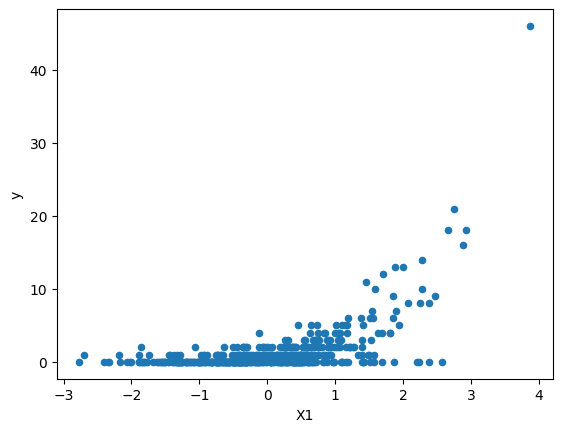

In [33]:
model.eval()
likelihood.eval()
with torch.no_grad():
    preds = likelihood(model(X))

results_df = pd.DataFrame(dict(
    y=y.cpu().numpy(),
    X1=X.cpu().numpy(),
    preds=preds.sample().median(axis=0).values.cpu().numpy()
))

results_df.plot.scatter("X1", "y")

<Axes: xlabel='X1', ylabel='preds'>

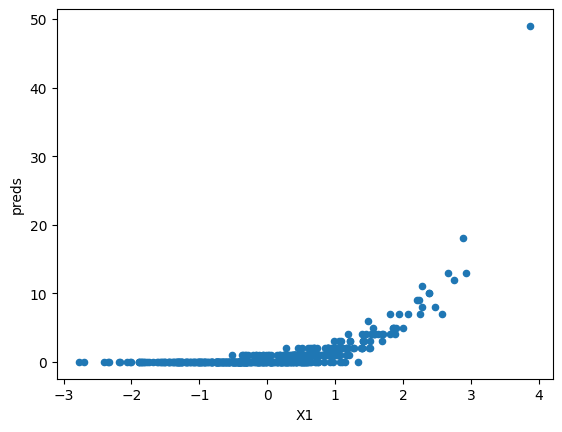

In [34]:
results_df.plot.scatter("X1", "preds")